# Generating a virtual marsh & tidal flat for Unreal Engine  -  LargeMarsh

### Loading some crucial python packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import time,os
%matplotlib inline
on=1;off=0

# Putting the screen to full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

ThreeGraphs=on

### Parameter definitions

In [2]:
# Hydrodynamic parameters
H0       = 0.02    # 0.02  [m] Imposed initial water layer thickness (equals the homogeneous equilibrium state)
g        = 9.8     # 9.8   [m/s^2] Gravitational acceleration constant
nn       = 0.05    # 0.05  [s m^(-1/3)] Gauckler-Manning friction coefficient (Chow, 1959); (Mariotti and Fagherazzi, 2012 JGR) => n=0.016
HCrit    = 0.001   # 0.001 [m] Critical water layer thickness (is always retained) in wetting-drying algorithm
slope    = 0.000   # 0.002 [m/m] Subsediment plane bed slope
DifU     = 0.05    # 0.01 [m^2/s] Turbulent eddy viscosity
Hin      = 0.00003 # 0.00003 [m] Rain

# Vegetation roughness parameters
Cb       = 20.0    # 20.0 Chezy roughness of the bed
Cd       = 2.0     # 2.0  Chezy friction coefficient for maximal vegetation density
Hv       = 0.5     # 0.5  Shoot length
kv       = 0.41    # 0.41 Von Karman constant
DifD     = 0.0001  # 0.0001 Lateral expansion of vegetation

# Sedimentation parameters
S_in     = 0.0010  # 0.001  [m/s] Sediment input
E0       = 10.0    # 7.0    [s-1] "Background" erosion rate.
pE       = 0.90    # 0.5 / 0.9 [-] Fraction by which sediment erosion is reduced if algae are at carrying capacity
D0       = 1e-3    # 0.0001 [m^2 s^-1] Sediment diffusivity in absence of algae
pD       = 1.0     # 0.0 - 1.0 [-] Fraction by which sediment diffusivity is reduced if algae are at carrying capacity

# Diatom growth & erosion parameters
rr       = 0.060   # 0.06  [1/s] Growth rate algae
kk       = 1.0     # 1.0   [g/m^2] Carrying capacity algae
Qq       = 0.5     # 0.5   [m] Value of water level where algae loss is (approximately) half max (higher Qq = lower overall loss rate)
Qs       = 0.006   # 0.006 [-] Fraction of initial (homogeneous) water layer thickness at which sedimentation rate is (approximately) half maximal
Ec       = 0.3     # 10.0  [-] Conversion factor from sediment erosion to algae loss

### Simulation settings

In [3]:
EndTime   = 2000    # 20      - total time
NumFrames = 50      # 50      - Number of times the figure is updated
dT        = 0.02    # 0.0005  - time step

### Spatial grid settings

In [4]:
# Thread block size
Block_Size_X   = 16     # 16
Block_Size_Y   = 16     # 16

# Number of blocks
# I define the Block_Number_ensions of the matrix as product of two numbers
# Makes it easier to keep them a multiple of something (16, 32) when using CUDA
Block_Number_X = 32     # 512
Block_Number_Y = 32     # 64

LengthX        = 100.0  # 800.0  Size of the domain in physical dimensions
LengthY        = 100.0  # 100.0  Size of the domain in physical dimensions

# Derived simulation parameters 
Grid_Width  = (Block_Size_X*Block_Number_X)     # Matrix A width
Grid_Height = (Block_Size_Y*Block_Number_Y)     # Matrix A height

dX = LengthX/Grid_Width   # space step
dY = LengthY/Grid_Height  # space step

print('Grid dimensions: %d x %d, dx x dy: %1.2f x %1.2f' % (Grid_Width,Grid_Height, dY, dY) )

Grid dimensions: 512 x 512, dx x dy: 0.20 x 0.20


### Precalculations

In [5]:
# Precomputation
h_homo = H0
u_homo = np.sqrt(slope)*h_homo**(2.0/3.0)/nn # Balance between downslope acceleration and friction
s_homo = S_in*u_homo*u_homo*(H0-HCrit)/(Qs+(H0-HCrit))/E0

### Some function definition

In [6]:
def logDown(x,x0,k): 
    return 1/(1+np.exp(-k*(x-x0)))

In [7]:
x=np.linspace(0,1,Grid_Width)
y=np.linspace(0,1,Grid_Height)
X,Y = np.meshgrid(x,y)

In [8]:
TidalFlatSlope  = 0.075 # m
TidalFlatHeight = 1.0 # m

Xs=np.int(0.15*Grid_Width)
Ys=np.int(0.25*Grid_Height)

Elevation = TidalFlatHeight*X**5/(X**5+TidalFlatSlope**5)

### Elevation map cross-section

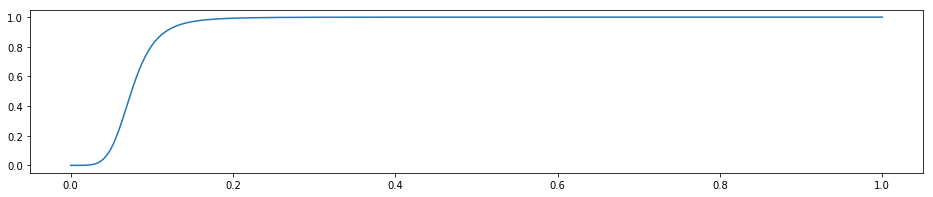

In [9]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 3), sharey='all')
ax.plot(X[np.int(Grid_Height/2),:],Elevation[np.int(Grid_Height/2),:]);

### Initializing the data arrays and giving them starting values

In [10]:
X, Y = np.meshgrid(np.linspace(0,1,Grid_Width), np.linspace(0,1,Grid_Height))

SeedNr=22

np.random.seed(SeedNr)
u = np.zeros((Grid_Width*Grid_Height)) + u_homo
v = np.zeros((Grid_Width*Grid_Height)) + 0.0
h = np.zeros((Grid_Width*Grid_Height)) + h_homo
# b = np.zeros((Grid_Width*Grid_Height)) + (1.0-X.flatten())*slope*LengthX;
b = Elevation
s = np.zeros((Grid_Width*Grid_Height)) + s_homo
d = (np.random.rand(Grid_Width*Grid_Height) < 0.0025) * 1.0 + 0.0

u_host = u.astype(np.float32)
v_host = v.astype(np.float32)
h_host = h.astype(np.float32)
b_host = b.astype(np.float32)
s_host = s.astype(np.float32)
d_host = d.astype(np.float32)

### Setting up the Graphics Card Unit (GPU) for OpenCL use

In [11]:
import pyopencl as cl

# Defining the device that is used
DeviceNr = 2   # 0 = CPU; 1 = Intel; 2 = AMD 
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '0'

platform = cl.get_platforms()
Devices  = platform[0].get_devices()
context  = cl.Context([Devices[DeviceNr]])
queue    = cl.CommandQueue(context)

print(" Activated Compute Device: %s\n" % Devices[DeviceNr].name)

mf = cl.mem_flags # Memory flags are set

# The array is allocated on the GPU and the initial values are copied onto it
u_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u_host)
v_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=v_host)
h_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=h_host)
b_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=b_host)
s_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=s_host)
d_g = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=d_host)

# Set up simulation parameters
global_size=u_host.shape
local_size=(Block_Number_X*Block_Number_Y,)

 Activated Compute Device: AMD Radeon Pro 460 Compute Engine



### Below, a string variable is created that contains all parameters to pass on to the GPU

In [12]:
# List of parameters for the OpenCL kernel. Seperate with comma without spaces
# Setting up the parameters for the Kernel

PassVars="dT,Grid_Width,Grid_Height,LengthX,LengthY,dX,dY,SeedNr," + \
         "H0,g,nn,HCrit,slope,DifU,Hin,Cb,Cd,Hv,kv,DifD,S_in,E0,pE,D0,pD,rr,kk,Qq,Qs,Ec"

PassVals=eval(PassVars)
PassVars=PassVars.split(',')
Params=""

for ii in range(len(PassVals)):
    Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"
    
# Params    

### Here, the main computing kernel is defined

In [13]:
BoundaryParams = """

#define Grid_Width_v   (Grid_Width)                         // Matrix A height for v
#define Grid_Height_v  (Grid_Height+1)                      // Matrix A width for v
#define Grid_Size_v    (Grid_Width_v*Grid_Height_v)         // Grid Size for v variable

// ---- Math functions etc ----------------------------------------------------
#define cl_max(A,B)    (float)(A>B?A:B)
#define cl_min(A,B)    (float)(A<B?A:B)

//---Specify homogenous Neumann or Dirichlet Boundary Conditions---

//Velocity u
#define UDirichletRight     ON
#define UValueRight         0.0
#define UDirichletLeft      OFF
#define UValueLeft          0.0
#define UDirichletTop       ON
#define UValueTop           0.0
#define UDirichletBottom    ON
#define UValueBottom        0.0
#define UNeumannRight       OFF
#define UNeumannLeft        ON
#define UNeumannTop         OFF
#define UNeumannBottom      OFF

//Velocity v
#define VDirichletRight     ON
#define VValueRight         0.0
#define VDirichletLeft      OFF
#define VValueLeft          0.0
#define VDirichletTop       ON
#define VValueTop           0.0
#define VDirichletBottom    ON
#define VValueBottom        0.0
#define VNeumannRight       OFF
#define VNeumannLeft        ON
#define VNeumannTop         OFF
#define VNeumannBottom      OFF

//Water depth a
#define ADirichletRight     OFF
#define AValueRight         0.0f
#define ADirichletLeft      OFF
#define AValueLeft          0.0f
#define ADirichletTop       OFF
#define AValueTop           0.0f
#define ADirichletBottom    OFF
#define AValueBottom        0.0f
#define ANeumannRight       ON
#define ANeumannLeft        ON
#define ANeumannTop         ON
#define ANeumannBottom      ON

//Bottom Elevation s
#define SDirichletRight     OFF
#define SValueRight         0.0
#define SDirichletLeft      ON
#define SValueLeft          0.0
#define SDirichletTop       OFF
#define SValueTop           0.0
#define SDirichletBottom    OFF
#define SValueBottom        0.0
#define SNeumannRight       ON
#define SNeumannLeft        OFF
#define SNeumannTop         ON
#define SNeumannBottom      ON

//Plant density
#define PDirichletRight     ON
#define PValueRight         1.0
#define PDirichletLeft      OFF
#define PValueLeft          0.0
#define PDirichletTop       ON
#define PValueTop           1.0
#define PDirichletBottom    ON
#define PValueBottom        1.0
#define PNeumannRight       OFF
#define PNeumannLeft        ON
#define PNeumannTop         OFF
#define PNeumannBottom      OFF

"""

### Here, the main computing kernel is defined

In [14]:
ComputeCode = """

float difco(float, float, size_t);
float d2_dxy2_S(__global float*, __global float*);

#define cl_max(A,B)	(A>B?A:B)
#define cl_min(A,B)	(A<B?A:B)

#define ON 1
#define OFF 0

////////////////////////////////////////////////////////////////////////////////
// Simulation kernel
////////////////////////////////////////////////////////////////////////////////

__kernel void SimulationKernel (__global float* u,
                                __global float* v,
                                __global float* h,
                                __global float* b,
                                __global float* s,
                                __global float* p
                                )
{
    // A-priori variable definition
    float du, dv, dh, ds, dx, dy, mul, vol;
    float uabs_u, uabs_v, uabs_a, Ct_u, Ct_v, h_u, h_v, h_eff;
    
    //--- Determining the position at which the current thread is computing---
    size_t current = get_global_id(0);
    
    // row and column number of variables: u, h, b, s, p
    int row		   = floor((float)current/(float)Grid_Width);
    int column	   = current%Grid_Width;
    
    // row and column number of variable:  v
    int row_v       = floor((float)current/(float)Grid_Width_v);
    int column_v    = current%Grid_Width_v;
    
    // --- Computing change in water depth ----------------------
    
    // Impose dirichlet conditions if grid point is located at the boundary and dirichlet condition
    
    if (ADirichletLeft == 1 && column == 0){
        h[current] = AValueLeft; }
    
    // Determine all other grid points
    
    else if(column >= ADirichletLeft && column < Grid_Width && row >= 0 && row < Grid_Height)
    {
       
        if (column==0){
            dx = dX/2.0;
        } else{
            dx = dX;
        }
        
        dy = dY; vol = dx*dy; mul = dT/vol;
        
        // --- Continuity equation -------------------------------------------------
        dh = - d_uh_dx(u,h,dx,dy) - d_vh_dy(v,h,dx,dy);
        
        // Updating water height
        h[current] = h[current] + mul*(vol*Hin+dh);
    }

    // A make-shift wetting-drying algoritm
    h[current]     = cl_max(h[current],HCrit);
    
    // --- Computing change in velocity in the y-directon ----------------------
    
    //Impose dirichlet conditions if grid point is located at the boundary and dirichlet condition
    
    if (VDirichletLeft == 1 && column_v ==0){
        v[current] = VValueLeft; }
    else if(VDirichletBottom == 1 && row_v ==0){
        v[current] = VValueBottom; }
    else if(VDirichletTop == 1 && row_v == Grid_Height_v-1){
        v[current] = VValueTop; }
    
    // Determine all other grid points
    
    else if(row_v >= VDirichletBottom && row_v < Grid_Height_v-VDirichletTop &&  column_v >= VDirichletLeft && column_v < Grid_Width_v){   //(0....Grid_Width-1)
    
        // Determine area of control volume velocity grid point
        if (column_v == 0){
            dx = dX/2.0;}
        else{
            dx = dX;}
        
        if(row_v == 0 || row_v == Grid_Height_v-1){
            dy = dY/2.0;}
        else{
            dy = dY;}
    
        vol = dx*dy; mul = dT/vol;
        
        // Averaging operations for velocity grid point
        h_v = Depth_v(h); Ct_v = Friction_v(h,p);  uabs_v = Netspeed_v(u,v);
            
        // Change in water velocity v in the Y direction
        dv = - dauv_dx(h,u,v,dx,dy)
             - dav2_dy(h,v,dx,dy)
             - g*h_v*dO_dy(h,s,b,dx,dy)
             + DifU*h_v*d2v_dxy2(v,dx,dy)
             - g/(Ct_v*Ct_v)*uabs_v*v[current]*vol;
        
        // Updating water flow
        v[current] = (h_v*v[current] + dv*mul)/h_v;
    }


    // --- Computing change in velocity in x direction ----------------------
    
    //Impose dirichlet conditions if grid point is located at the boundary and dirichlet condition
    
    if(UDirichletRight == 1 && column == Grid_Width-1){
        u[current] = UValueRight; }
    
     // Determine all other grid points
    
    else if(row >= 0 && row < Grid_Height &&  column >= 0 && column < Grid_Width-UDirichletRight)
    {
        // Determine area of control volume velocity grid point
        if (column == Grid_Width-1){
            dx = dX/2.0;}
        else{
            dx = dX;}
    
        dy = dY; vol = dx*dy; mul =  dT/vol;
        
        //Averaging operations for u velocity point
        Ct_u = Friction_u(h,p); h_u = Depth_u(h); uabs_u = Netspeed_u(u,v);
        
        // Change in water velocity u in the X direction
        du = - dau2_dx(h,u,dx,dy)
            - dauv_dy(h,u,v,dx,dy)
            - g*h_u*dO_dx(h,s,b,dx,dy)
            + DifU*h_u*d2u_dxy2(u,dx,dy)
            - g/(Ct_u*Ct_u)*uabs_u*u[current]*vol;
        
        // Updating water flow
        u[current] = (h_u*u[current] + du*mul)/h_u;
    }
    
    
    // --- Computing change in plant density----------------------
    
    //Impose dirichlet conditions if grid point is located at the boundary and dirichlet condition
    
    // float Ct=(Ct_u+Ct_v)/2;
    
    if (PDirichletLeft == 1 && column == 0){
        p[current] = PValueLeft; }
     // Determine all other grid points
    else  if (PDirichletRight == 1 && column == (Grid_Width-1)){
        p[current] = PValueRight; }
     // Determine all other grid points  
    else  if (PDirichletTop == 1 && row == 0){
        p[current] = PValueTop; }
     // Determine all other grid points  
    else  if (PDirichletBottom == 1 && row == (Grid_Height-1)){
        p[current] = PValueBottom; }
     // Determine all other grid points       
    else if(column >= 0 && column < Grid_Width-1 && row >= 0 && row < Grid_Height-1)
    {
        
        // Determine area of control volume vegetation grid point
        if (column==0){
            dx = dX/2.0;}
        else{
            dx = dX;}
        
        dy = dY; vol = dx*dy; mul = dT/vol;
        
        // Averaging operation
        uabs_a     =  Netspeed_a(u,v);
        
        h_eff=h[current]-HCrit;
        
        float rrx = rr / (1.0f+exp((float)(-0.05*((float)column-100.0))));
        
        // --- Algae differential equation --------------------------------------
        float dp = rrx*p[current]*(1 - p[current]/kk)*Qq/(Qq+h_eff)*vol
                   - Ec*p[current]*uabs_a*vol
                   + DifD*d2s_dxy2(p,dx,dy) ;
        
        // Updating vegetation density
        p[current] = p[current] + mul*dp;
    
    }
    
    
     // --- Computing change in bottom elevation----------------------
    
    //Impose dirichlet conditions if grid point is located at the boundary and dirichlet condition
    
    if (SDirichletLeft == 1 && column == 0){
        s[current] = SValueLeft; }
    
     // Determine all other grid points
    
    else if(column >= SDirichletLeft && column < Grid_Width && row >= 0 && row < Grid_Height)
    {
        // Determine area of control volume sedimentation grid point
        if (column==0){
            dx = dX/2.0;
        } else{
            dx = dX;
        }
        
        dy = dY; vol = dx*dy; mul = dT/vol;
        
        // Averaging operation
        uabs_a     =  Netspeed_a(u,v);
        
        h_eff=h[current]-HCrit;
        
        // --- Sediment differential equation --------------------------------------
        ds = S_in*h_eff/(Qs+h_eff)*vol
             - E0*(1-pE*p[current]/kk)*s[current]*uabs_a*uabs_a*vol                              //- E0*(1-pE*d[current]/kk)*uabs*0.02*s[current]
             + D0*d2s_dxy2(s,dx,dy);
        
        // Updating sediment height
        s[current] = s[current] + mul*ds;
    }

} // End SimulationKernel 

"""

### Next, the functions d2_dxy2() and Neumannboundaries are loaded

In [15]:
with open('HydroFunctionsSG_iPy.cl', 'r') as myfile:
   HydroFunctions = myfile.read()

## Here the kernel is compiled

In [16]:
program = cl.Program(context, Params + BoundaryParams + HydroFunctions + ComputeCode).build()

/Users/johank/anaconda3/lib/python3.7/site-packages/pyopencl/__init__.py:235: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


In [17]:
ComputerKernelText = Params + BoundaryParams + HydroFunctions + ComputeCode
with open("ComputerKernelText.txt", "w") as text_file:
    print(ComputerKernelText, file=text_file)

# print(ComputerKernelText)

### The main simulation loop

In [18]:
from ipywidgets import FloatProgress
from IPython.display import display

# Setting up a progress bar for the simulation
print("Progress :");
PB = FloatProgress(min=0, max=NumFrames); display(PB) 

us = np.zeros((Grid_Height, Grid_Width, NumFrames))
vs = np.zeros((Grid_Height, Grid_Width, NumFrames))
hs = np.zeros((Grid_Height, Grid_Width, NumFrames))
bs = np.zeros((Grid_Height, Grid_Width, NumFrames))
ss = np.zeros((Grid_Height, Grid_Width, NumFrames))
ds = np.zeros((Grid_Height, Grid_Width, NumFrames))

start_time = time.time() # Starting a timer:

# Starting the loop
for count in range(NumFrames):
    
    # The simulation is executed here for EndTime/dT/NumFrames times
    for jj in range(int(EndTime/dT/NumFrames)):
        program.SimulationKernel(queue, global_size, None, u_g, v_g, h_g, b_g, s_g, d_g)

    # Get the data from the GPU
    cl.enqueue_copy(queue, u_host, u_g)
    cl.enqueue_copy(queue, v_host, v_g)
    cl.enqueue_copy(queue, h_host, h_g)
    cl.enqueue_copy(queue, b_host, b_g)
    cl.enqueue_copy(queue, s_host, s_g)
    cl.enqueue_copy(queue, d_host, d_g)

    # We store the state of the system for <NumPlot> different times.
    us[:,:,count] = u_host.reshape(Grid_Height,Grid_Width)
    vs[:,:,count] = v_host.reshape(Grid_Height,Grid_Width)
    hs[:,:,count] = h_host.reshape(Grid_Height,Grid_Width)
    bs[:,:,count] = b_host.reshape(Grid_Height,Grid_Width)
    ss[:,:,count] = s_host.reshape(Grid_Height,Grid_Width)
    ds[:,:,count] = d_host.reshape(Grid_Height,Grid_Width)    
    
    PB.value += 1 # signal to increment the progress bar
    
print(" Simulation took      : %1.1f (s)" % (time.time() - start_time))

Progress :


FloatProgress(value=0.0, max=50.0)

 Simulation took      : 127.5 (s)


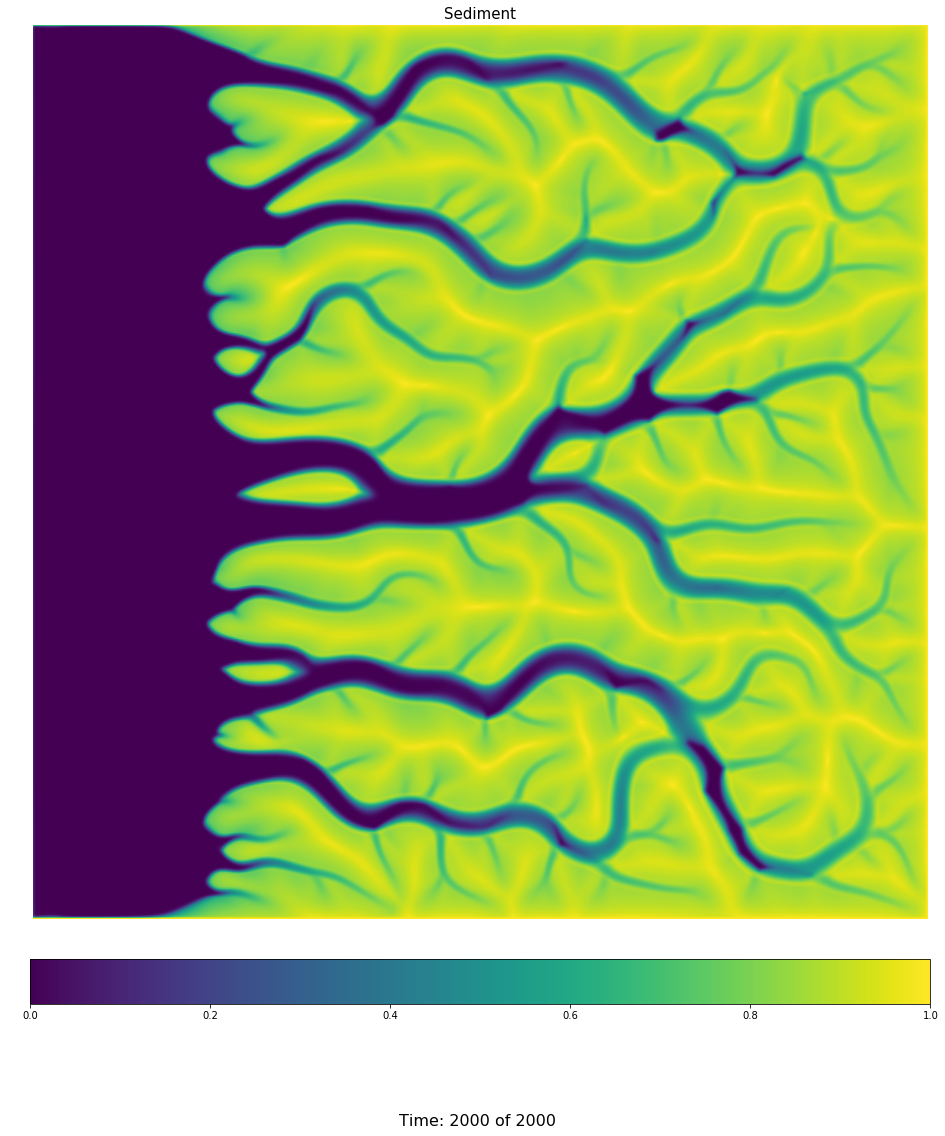

In [19]:
BestFrame=26

if (True):
    fig, ax = plt.subplots(1, 1, figsize=(18, 18))

    NetSpeed=np.sqrt(us[:,:,BestFrame]**2+vs[:,:,NumFrames-1]**2)

    im1=ax.imshow(ds[:,:,BestFrame], animated=True, interpolation='bilinear')
    ax.set_title('Sediment', fontsize=15)
    text1=fig.suptitle("Time: %1.0f of %1.0f" % (EndTime, EndTime), x=0.51, y=0.04, fontsize=16);
    ax.set_axis_off()

    f=fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04, orientation='horizontal')

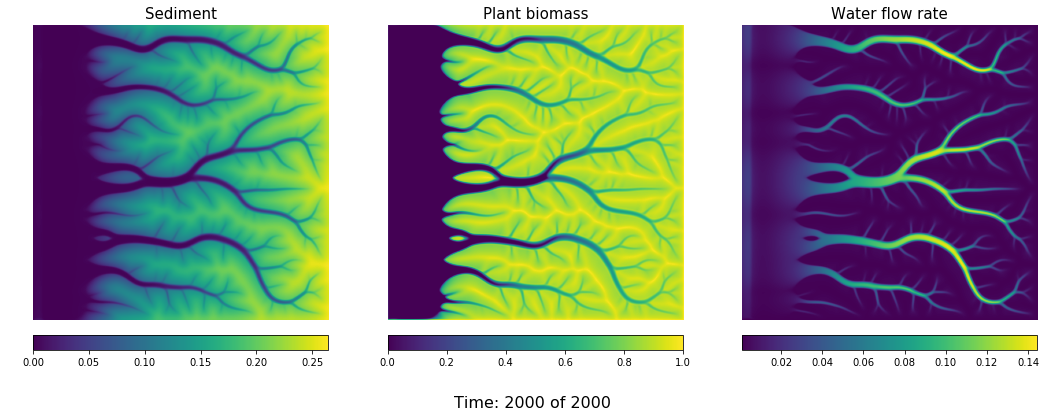

In [20]:
if (True):
    fig, ax = plt.subplots(1, 3, figsize=(18, 7))

    NetSpeed=np.sqrt(us[:,:,NumFrames-1]**2+vs[:,:,NumFrames-1]**2)

    im1=ax[0].imshow(ss[:,:,NumFrames-1], animated=True, interpolation='bilinear')
    ax[0].set_title('Sediment', fontsize=15)
    text1=fig.suptitle("Time: %1.0f of %1.0f" % (EndTime, EndTime), x=0.51, y=0.04, fontsize=16);
    ax[0].set_axis_off()

    f=fig.colorbar(im1, ax=ax[0], fraction=0.046, pad=0.04, orientation='horizontal')

    im2=ax[1].imshow(ds[:,:,NumFrames-1], animated=True, interpolation='bilinear')
    ax[1].set_title('Plant biomass', fontsize=15)
    ax[1].set_axis_off()

    f=fig.colorbar(im2, ax=ax[1], fraction=0.046, pad=0.04, orientation='horizontal')
    
    im3=ax[2].imshow(hs[:,:,NumFrames-1], animated=True, interpolation='bilinear')
    ax[2].set_title('Water flow rate', fontsize=15)
    ax[2].set_axis_off()

    f=fig.colorbar(im3, ax=ax[2], fraction=0.046, pad=0.04, orientation='horizontal')

### Making an animation

In [21]:
if (True):
    from matplotlib import animation, rc

    def updatefig(i): # To update the image at each iteration
        global us,vs,ds
        NetSpeed=np.sqrt(us[:,:,i]**2+vs[:,:,i]**2)
        im1.set_array(ss[:,:,i])
        im2.set_array(ds[:,:,i])
        im3.set_array(NetSpeed)
        text1.set_text("Time: %1.0f of %1.0f" % ((i+1)/NumFrames*EndTime, EndTime));
        return im1,im2

    ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = NumFrames, repeat=False, blit=True)

    from IPython.display import HTML
    # HTML(ani.to_html5_video())
    
    # write to an mp4 movie
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=10, metadata=dict(artist='Johan van de Koppel'), bitrate=1800)
    ani.save('LargeMarsh.mp4', writer=writer)

In [22]:
HTML(ani.to_html5_video())

### Saving the data to file

In [23]:
NetSpeed=np.sqrt(us[:,:,BestFrame]**2+vs[:,:,BestFrame]**2)
np.savez('LargeMarsh',E=Elevation, S=ss[:,:,BestFrame], B=ds[:,:,BestFrame], H=hs[:,:,BestFrame], UV=NetSpeed)
np.savez('LargeMarsh_All', Us=us, Vs=vs, Hs=hs, Bs=bs, Ss=ss, Ds=ds, NumFrames=NumFrames, EndTime=EndTime)

In [24]:
os.system("say finished");

© Johan van de Koppel, NIOZ-Yerseke 2018